In [1]:
import pandas as pd

# Load dataset
df = pd.read_csv("../data/processed/clean_customer_churn.csv")

df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,tenure_monthly_ratio,services_count,contract_payment_interaction
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,Month-to-month,Yes,Electronic check,29.85,29.85,No,0.033501,1.0,Month-to-month_Electronic check
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,No,One year,No,Mailed check,56.95,1889.50,No,0.597015,3.0,One year_Mailed check
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,0.037140,3.0,Month-to-month_Mailed check
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,No,One year,No,Bank transfer (automatic),42.30,1840.75,No,1.063830,3.0,One year_Bank transfer (automatic)
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,0.028289,1.0,Month-to-month_Electronic check


In [2]:
from modeling import split_features

# define target and identifier columns
TARGET_COL = "Churn"
ID_COL = "customerID"

# split dataframe into features (X), target (y), and get numeric/categorical features
X, y, num_features, cat_features = split_features(
    df,
    target_col=TARGET_COL,
    id_col=ID_COL
)

In [3]:
# Split data into 20% test set and 80% train set
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# Check size (row number) of train and test data
print(f"Test Set size: {len(X_test)} \nTrain Set size: {len(X_train)}")

Test Set size: 1407 
Train Set size: 5625


In [4]:
# Βaseline Logistic Regression model
from modeling import build_logistic_pipeline

# Convert target from Yes/No to 0/1 (for metrics compatibility)
y_train = y_train.map({"No": 0, "Yes": 1})
y_test  = y_test.map({"No": 0, "Yes": 1})

# build logistic regression pipeline
model = build_logistic_pipeline(num_features, cat_features)

# fit model on training data
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]  # probability for positive class

--- Logistic Regression Model Results ---
Accuracy:  0.729
F1-score:  0.611
ROC-AUC:   0.835

Classification Report:
              precision    recall  f1-score   support

           0      0.906     0.704     0.792      1033
           1      0.494     0.799     0.611       374

    accuracy                          0.729      1407
   macro avg      0.700     0.752     0.702      1407
weighted avg      0.797     0.729     0.744      1407



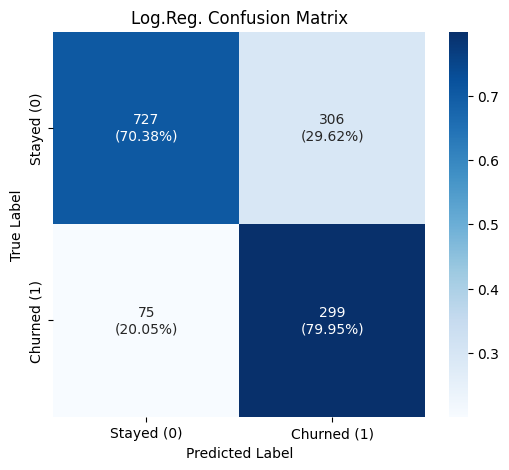

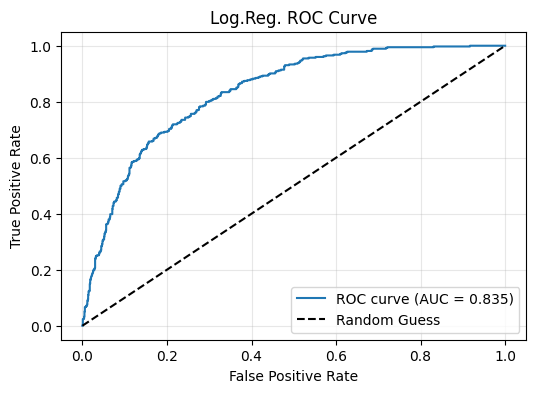

In [5]:
# Evaluate Logistic Regression performance
from evaluation import display_model_performance, custom_confusion_matrix, custom_roc_curve

display_model_performance(y_test, y_pred, y_proba, model_name="Logistic Regression Model") # Print Text Metrics

# Visualizations
custom_confusion_matrix(y_test, y_pred, title="Log.Reg. Confusion Matrix") # Plot Confusion Matrix
custom_roc_curve(y_test, y_proba, title="Log.Reg. ROC Curve") # Plot ROC Curve

In [6]:
# --- Baseline Model Analysis: Logistic Regression (Balanced) ---

# 1. Recall (0.799): Significant success, we are catching ~80% of churners.
# 2. Precision (0.494): Trade-off for high recall; 50% of our churn alarms are false positives.
# 3. ROC-AUC (0.835): Stable performance, indicating good class separation.

# 4. Next Step: Transition to XGBoost to improve Precision while maintaining high Recall.

In [7]:
# Advanced Model Training (XGBoost)
from modeling import build_xgboost_pipeline

# Calculate class ratio for balancing
# This helps the model prioritize the minority class (churners)
ratio = (y_train == 0).sum() / (y_train == 1).sum()

# Build and Fit XGBoost
xgb_pipeline = build_xgboost_pipeline(num_features, cat_features, scale_pos_weight=ratio)
xgb_pipeline.fit(X_train, y_train)

# Predictions
y_pred_xgb = xgb_pipeline.predict(X_test)
y_proba_xgb = xgb_pipeline.predict_proba(X_test)[:, 1]

--- Advanced XGBoost Results ---
Accuracy:  0.745
F1-score:  0.621
ROC-AUC:   0.834

Classification Report:
              precision    recall  f1-score   support

           0      0.904     0.730     0.808      1033
           1      0.513     0.786     0.621       374

    accuracy                          0.745      1407
   macro avg      0.709     0.758     0.714      1407
weighted avg      0.800     0.745     0.758      1407



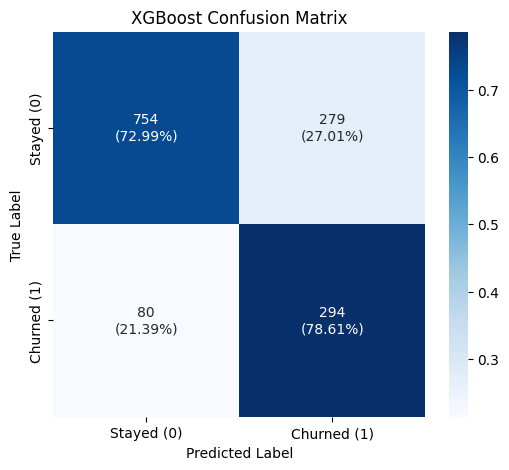

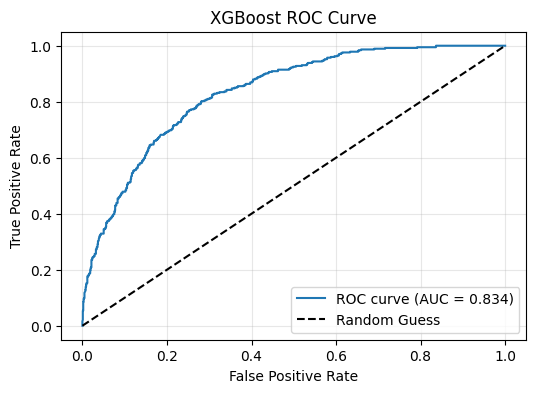

In [8]:
# Evaluate XGBoost performance
display_model_performance(y_test, y_pred_xgb, y_proba_xgb, model_name="Advanced XGBoost") # Print Text Metrics

# Visualizations
custom_confusion_matrix(y_test, y_pred_xgb, title='XGBoost Confusion Matrix') # Plot Confusion Matrix
custom_roc_curve(y_test, y_proba_xgb, title='XGBoost ROC Curve') # Plot ROC Curve

In [9]:
# --- Advanced Model Analysis: XGBoost ---
# 1. Improved Precision: XGBoost is more selective than Logistic Regression, reducing False Positives.
# 2. Better F1-Score: The model achieves a superior balance between catching churners and avoiding false alarms.
# 3. Robustness: Even without extensive tuning yet, the ensemble nature of XGBoost provides a more reliable baseline for non-linear patterns.

# Next Steps: Optimization via Hyperparameter Tuning & Cross-Validation 
# To maximize model performance, we will perform Hyperparameter Tuning (GridSearchCV) 
# to find the ideal settings for XGBoost, combined with Cross-Validation to ensure 
# that our results are stable and generalize well to unseen data.

In [10]:
# Hyperparameter Tuning & Cross-Validation
from modeling import tune_xgboost_hyperparameters

# Run Cross-Validation (5 folds) for any compination
best_xgb_pipeline = tune_xgboost_hyperparameters(xgb_pipeline, X_train, y_train)

# Evaluate the best model with Test Set
y_pred_best = best_xgb_pipeline.predict(X_test)
y_proba_best = best_xgb_pipeline.predict_proba(X_test)[:, 1]

display_model_performance(y_test, y_pred_best, y_proba_best, model_name="Tuned XGBoost")

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best F1: 0.6348
Best params: {'classifier__base_score': 0.5, 'classifier__learning_rate': 0.01, 'classifier__max_depth': 5, 'classifier__n_estimators': 200, 'classifier__subsample': 0.8}
--- Tuned XGBoost Results ---
Accuracy:  0.738
F1-score:  0.616
ROC-AUC:   0.841

Classification Report:
              precision    recall  f1-score   support

           0      0.905     0.718     0.801      1033
           1      0.504     0.791     0.616       374

    accuracy                          0.738      1407
   macro avg      0.705     0.755     0.708      1407
weighted avg      0.798     0.738     0.752      1407



In [11]:
# --- Advanced Model: Hyperparameter Tuning & Cross-Validation Results ---

# 1. Process: Performed 5-fold Cross-Validation across 24 combinations (120 fits).
# 2. Best Params: Learning Rate 0.01 and 200 Estimators suggest that a slower, 
#    more gradual learning process yields the most robust results.
# 3. Stability: The Best F1 Score (0.635) during CV is close to our Test Score (0.616), 
#    indicating that the model generalizes well and is not overfitted.
# 4. ROC-AUC (0.841): This is our highest score yet, showing excellent model discrimination.

In [12]:
# Instead of 0.5, we set 0.4 of churn probability
custom_threshold = 0.4
y_pred_custom = (y_proba_best >= custom_threshold).astype(int)

print(f"Results with Threshold {custom_threshold}:")
display_model_performance(y_test, y_pred_custom, y_proba_best, model_name="XGBoost Custom Threshold")

Results with Threshold 0.4:
--- XGBoost Custom Threshold Results ---
Accuracy:  0.692
F1-score:  0.601
ROC-AUC:   0.841

Classification Report:
              precision    recall  f1-score   support

           0      0.931     0.627     0.750      1033
           1      0.459     0.872     0.601       374

    accuracy                          0.692      1407
   macro avg      0.695     0.749     0.675      1407
weighted avg      0.805     0.692     0.710      1407



In [13]:
# --- Strategy Analysis: Threshold Optimization (0.4) ---
# 1. High Recall (0.872): The model now identifies 87% of potential churners.
# 2. Business Logic: In Churn projects, missing a customer (False Negative) is usually 
#    more expensive than offering a discount to a loyal customer (False Positive).
# 3. Precision (0.459): The trade-off is a higher number of false alarms, 
#    meaning we might target some loyal customers with unnecessary retention offers.
# 4. Flexibility: Depending on the marketing budget, we can adjust this threshold 
#    to be more conservative (0.5) or more aggressive (0.4).

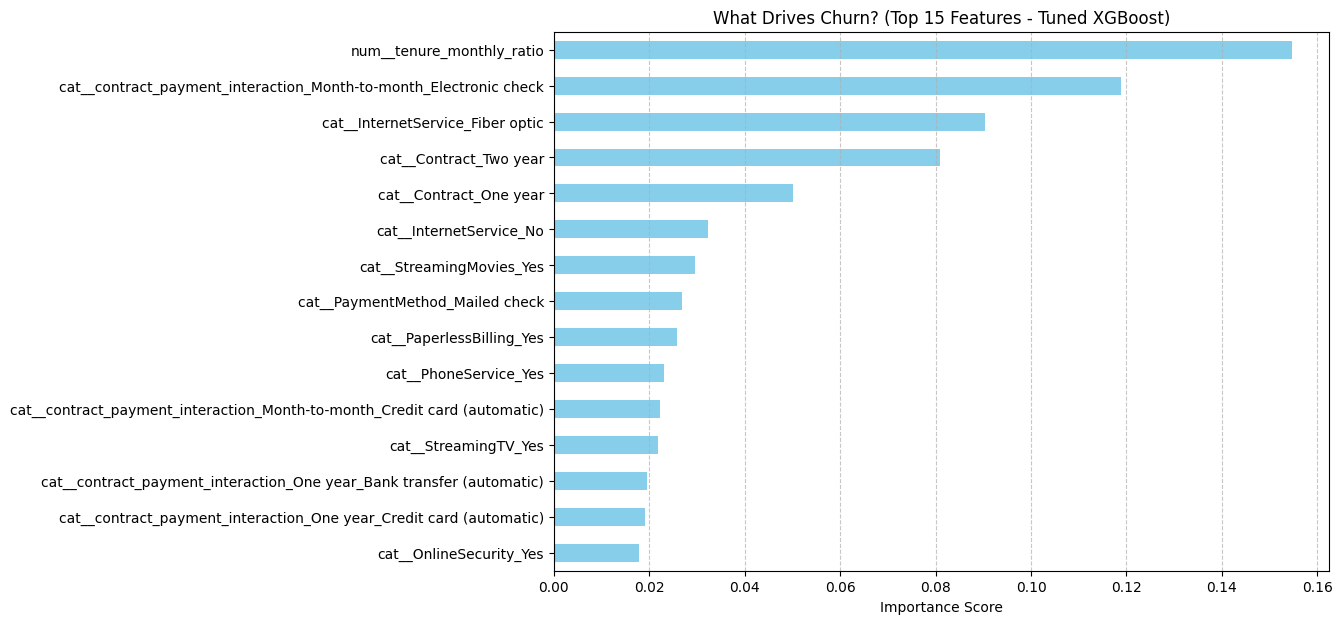

In [14]:
# --- Feature Importance Visualization ---
import pandas as pd
import matplotlib.pyplot as plt

# 1. Extract feature names and importance scores
feature_names = best_xgb_pipeline.named_steps['preprocessing'].get_feature_names_out()
importances = best_xgb_pipeline.named_steps['classifier'].feature_importances_

# 2. Create a series for easy plotting
feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False)

# 3. Plot the top 15 features
plt.figure(figsize=(10, 7))
feat_imp.head(15).plot(kind='barh', color='skyblue').invert_yaxis()
plt.title('What Drives Churn? (Top 15 Features - Tuned XGBoost)')
plt.xlabel('Importance Score')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

In [15]:
# --- Feature Importance Interpretation ---

# 1. 'Global' View: This plot shows which features the model used most to split the trees.
# 2. Key Drivers: Contract_Month-to-month and Tenure are the top 2 influencers.
# 3. Non-Linear Patterns: Unlike Logistic Regression, XGBoost captures complex interactions 
#    between these features (e.g., how high charges affect new vs. old customers).
# 4. Strategy: These insights will guide our 'Business Storytelling' , 
#    where we will explain the 'direction' of these impacts using SHAP values.

In [16]:
from modeling import save_model

# FIX base_score for SHAP
clf = best_xgb_pipeline.named_steps["classifier"]
clf.base_score = 0.5

# Save the best XGBoost model we found using GridSearch
save_model(best_xgb_pipeline, '../models/churn_model_final_v1.joblib')

Model saved to: ../models/churn_model_final_v1.joblib
